# Model output distributions
In this book i try to check out the trained models output w.r.t. real output.

## Model parameters

In [4]:
import pandas as pd
import numpy as np
import optuna

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

In [6]:
# TODO: don't forget device='cuda'
xgb_parameters = {
    'max_leaves': 40,
    'max_depth': 281,
    'learning_rate': 0.08792944959024201,
    'n_estimators': 632,
    'subsample': 0.6900703019224456,
    'colsample_bytree': 0.767812706804894,
    # 'device': 'cuda',
}

lgbm_parameters = {
    'num_leaves': 66,
    'max_depth': 449,
    'learning_rate': 0.03502441310895256,
    'n_estimators': 820,
    'subsample': 0.592592101509771,
    'colsample_bytree': 0.6862792428425046
}

sgd_parameters = {
    'penalty': None,
    'alpha': 4.223601774273774,
    'l1_ratio': 0.8940821225850496
}

bayes_ridge_parameters = {
    'alpha_1': 0.012972867153230679,
    'alpha_2': 0.03937728242649084,
    'lambda_1': 5.3000736672220825e-06,
    'lambda_2': 0.07761015011781103
}

cat_parameters = {
    'learning_rate': 0.029247253288660423,
    'depth': 9,
    'l2_leaf_reg': 6.715144149188259,
    'random_strength': 0.29075067665837756,
    'bagging_temperature': 0.3097108651010562,
    # 'task_type': 'GPU',
}

## Data, Evaluation

In [11]:
df = pd.read_csv('data/train_pp.csv')
test_df = pd.read_csv('data/test_pp.csv')

X = df.drop(['accident_risk', 'id'], axis=1)
y = df['accident_risk']

In [13]:
def submission_generator(trained_model):
    test_df_preprocessed = test_df.drop('id', axis=1)
    return pd.concat([test_df['id'], pd.Series(trained_model.predict(test_df_preprocessed))], axis=1).rename({0: 'accident_risk'}, axis=1)

## Model prepration

In [36]:
xgb_model = XGBRegressor(**xgb_parameters)
lgbm_model = LGBMRegressor(**lgbm_parameters)
sgd_model = SGDRegressor(**sgd_parameters)
bayes_model = BayesianRidge(**bayes_ridge_parameters)
cat_model = CatBoostRegressor(**cat_parameters)

## Model train/evaluate

In [27]:
xgb_model.fit(X, y)
xgb_predictions = xgb_model.predict(X)

In [29]:
lgbm_model.fit(X, y)
lgbm_predictions = lgbm_model.predict(X)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 517754, number of used features: 17
[LightGBM] [Info] Start training from score 0.352377


In [31]:
sgd_model.fit(X, y)
sgd_predictions = sgd_model.predict(X)

In [33]:
bayes_model.fit(X, y)
bayes_predictions = bayes_model.predict(X)

In [42]:
cat_model.fit(X, y)
cat_predictions = cat_model.predict(X)

0:	learn: 0.1622448	total: 24.7ms	remaining: 24.7s
1:	learn: 0.1581982	total: 43.9ms	remaining: 21.9s
2:	learn: 0.1542944	total: 61.9ms	remaining: 20.6s
3:	learn: 0.1505159	total: 80ms	remaining: 19.9s
4:	learn: 0.1468672	total: 97.6ms	remaining: 19.4s
5:	learn: 0.1433309	total: 115ms	remaining: 19.1s
6:	learn: 0.1398977	total: 133ms	remaining: 18.9s
7:	learn: 0.1365922	total: 151ms	remaining: 18.7s
8:	learn: 0.1334075	total: 168ms	remaining: 18.5s
9:	learn: 0.1303172	total: 186ms	remaining: 18.4s
10:	learn: 0.1273339	total: 203ms	remaining: 18.3s
11:	learn: 0.1244534	total: 221ms	remaining: 18.2s
12:	learn: 0.1216606	total: 240ms	remaining: 18.2s
13:	learn: 0.1189726	total: 257ms	remaining: 18.1s
14:	learn: 0.1163908	total: 276ms	remaining: 18.1s
15:	learn: 0.1138954	total: 294ms	remaining: 18.1s
16:	learn: 0.1114794	total: 311ms	remaining: 18s
17:	learn: 0.1091612	total: 329ms	remaining: 17.9s
18:	learn: 0.1069214	total: 347ms	remaining: 17.9s
19:	learn: 0.1047684	total: 365ms	remain

## CDF

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

In [74]:
predictions = {
    'XGB': xgb_predictions,
    'LGBM': lgbm_predictions,
    'SGD': sgd_predictions,
    'Bayes': bayes_predictions,
    'CatBoost': cat_predictions,
    'Original': y,
}

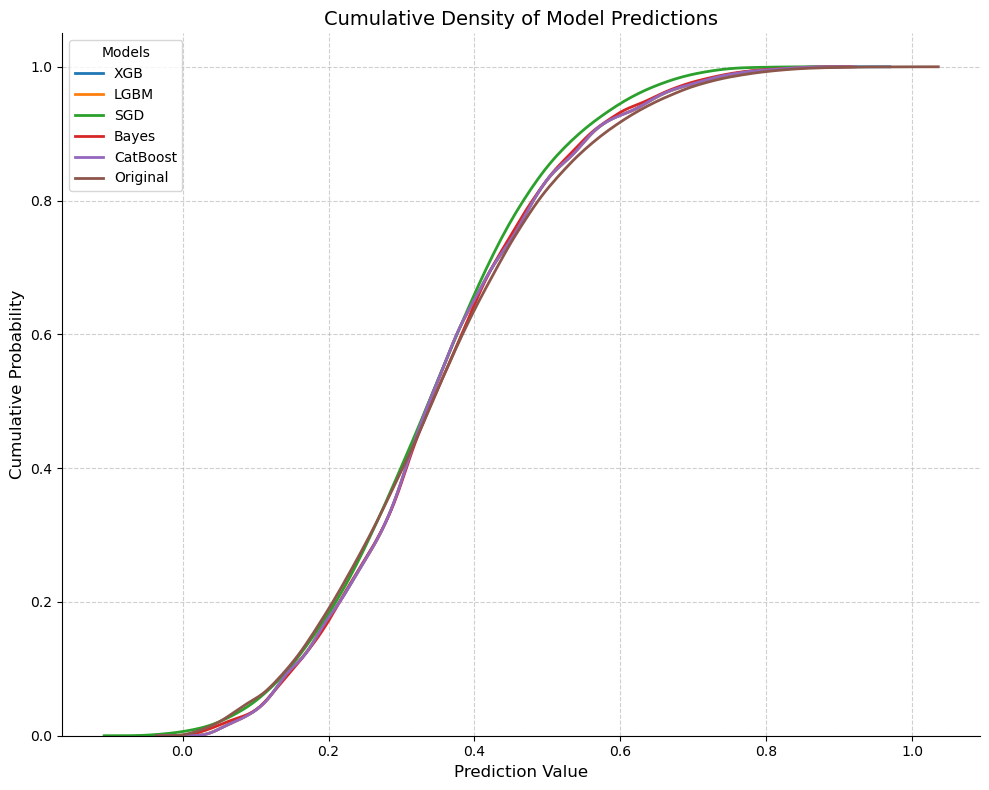

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10, 8))

for name, model_predictions in predictions.items():
    sns.kdeplot(
        model_predictions,
        cumulative=True,
        label=name,
        linewidth=2,
        fill=False,
    )

plt.title("Cumulative Density of Model Predictions", fontsize=14)
plt.xlabel("Prediction Value", fontsize=12)
plt.ylabel("Cumulative Probability", fontsize=12)
plt.legend(title="Models", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
sns.despine()

plt.tight_layout()
plt.show()

In [88]:
from scipy.stats import ks_2samp
import itertools

for (name1, preds1), (name2, preds2) in itertools.combinations(predictions.items(), 2):
    ks_stat, p_value = ks_2samp(preds1, preds2)
    print(f"{name1} vs {name2}: KS={ks_stat:.3f}, p={p_value:.3e}")

XGB vs LGBM: KS=0.004, p=1.329e-03
XGB vs SGD: KS=0.033, p=8.356e-252
XGB vs Bayes: KS=0.020, p=3.142e-87
XGB vs CatBoost: KS=0.003, p=6.119e-03
XGB vs Original: KS=0.043, p=0.000e+00
LGBM vs SGD: KS=0.033, p=7.093e-251
LGBM vs Bayes: KS=0.020, p=2.328e-88
LGBM vs CatBoost: KS=0.003, p=6.454e-02
LGBM vs Original: KS=0.042, p=0.000e+00
SGD vs Bayes: KS=0.035, p=2.068e-270
SGD vs CatBoost: KS=0.033, p=1.891e-243
SGD vs Original: KS=0.043, p=0.000e+00
Bayes vs CatBoost: KS=0.019, p=8.794e-84
Bayes vs Original: KS=0.043, p=0.000e+00
CatBoost vs Original: KS=0.042, p=0.000e+00
